# 1. Quick start: read csv and flatten json fields

Hi! This notebook just loads the data and flattens the json fields. 
I have put the code in one function so you can copy it easily.

Also, I dumped the processed dataframes to disk so they are easily importable from within another kernel.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib as plt
from pandas.io.json import json_normalize

def load_df(csv_path='../input/train_v2.csv', nrows=70000):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(list(df[column]))
        #column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

print(os.listdir("../input"))

['sample_submission_v2.csv', 'test_v2.csv', 'train_v2.csv']


In [ ]:
%%time
df_small = load_df(nrows=20000)

In [2]:
%%time
df_train = load_df()
#df_test = load_df("../input/test_v2.csv")

Loaded train_v2.csv. Shape: (70000, 59)
CPU times: user 18.1 s, sys: 3.15 s, total: 21.2 s
Wall time: 21.4 s


In [ ]:
%%time
df_train.to_csv("train-flattened.csv", index=False)
#df_test.to_csv("test-flattened.csv", index=False)

CPU times: user 228 ms, sys: 40 ms, total: 268 ms
Wall time: 278 ms


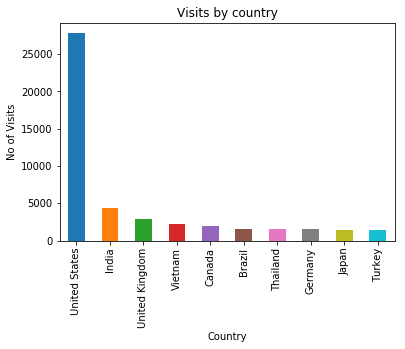

In [3]:
%%time
#top_10 =df_train['country'].value_counts()[:10]
#print(top_10)
#print(df_train[['visits','country']])
import matplotlib.pyplot as plt
gp =df_train.groupby('country')['fullVisitorId'].count().sort_values(ascending=False)[:10]

gp.plot(kind='bar',title='Visits by country')
plt.xlabel('Country')
plt.ylabel('No of Visits')
#gp.plot.bar(x='country', y='count')

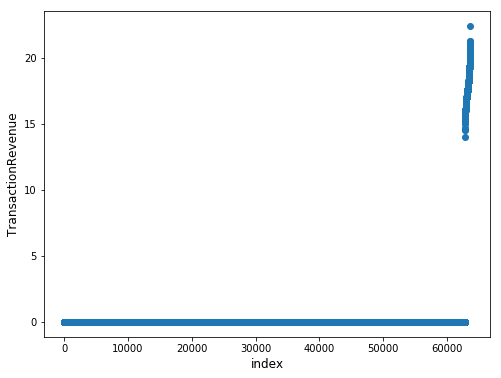

In [4]:

df_train["transactionRevenue"] = df_train["transactionRevenue"].astype('float')
gdf = df_train.groupby("fullVisitorId")["transactionRevenue"].sum().reset_index()

#gdf1 = gdf.query('transactionRevenue>0')

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [6]:

import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


In [7]:
cnt_srs = df_train.groupby('source')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = df_train.groupby('medium')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'blue')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'blue')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig)


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [8]:
import datetime 
def datemodify(df):
    df["date"] = df["date"].astype(str)
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    df["date"] = pd.to_datetime(df["date"])
    
    #df["month"]   = df['date'].dt.month
    #df["day"]     = df['date'].dt.day
    #df["weekday"] = df['date'].dt.weekday
    return df 

df_train['date'] = df_train['date'].astype(str)
df_train["date"] = df_train["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
df_train['date'] = pd.to_datetime(df_train['date'])

tmp = df_train['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp = tmp.rename(columns = {"index" : "dateX", "date" : "visits"})

tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["visits"])
layout = go.Layout(title="Visits by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
py.iplot(fig)


In [9]:
tmp = df_train.groupby("date").agg({"transactionRevenue" : "mean"}).reset_index()
tmp = tmp.rename(columns = {"date" : "dateX", "transactionRevenue" : "mean_revenue"})
tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["mean_revenue"])
layout = go.Layout(title="MonthlyRevenue by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
py.iplot(fig)

Text(0,0.5,'Non Zero Revenue')

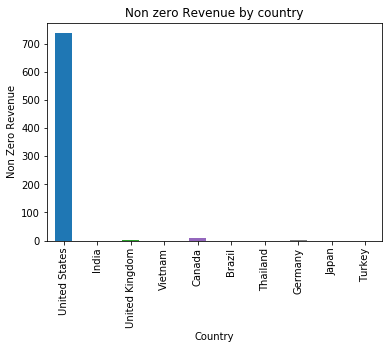

In [11]:
cntr_rev = df_train.groupby('country')['transactionRevenue'].agg(['size', 'count', 'mean'])
cntr_rev.columns = ["count", "count of non-zero revenue", "mean"]
cntr_rev = cntr_rev.sort_values(by="count", ascending=False)
#trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
cntr_rev["count of non-zero revenue"].head(10).plot(kind='bar',title='Non zero Revenue by country')
plt.xlabel('Country')
plt.ylabel('Non Zero Revenue')